#### <font color='blue'> <h1 align="center"> Integrated Project : Data Mining Phase [Sales Peak Prediction Model] <br> 4GL8_2022/2023 <br> <font color='red'></font> </h1> </font>

# Contents
 
*  Importing Liabraries
*  Exploring and Modifying data
*  Sales Predictions
*  Models Implimentation
*  Analysing Trends

In [1]:
#importing Liabraries
import numpy as np 
import pandas as pd 
import plotly.express as px
import plotly.graph_objs as go
import plotly as py
from plotly import tools
from plotly.offline import iplot
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from math import sqrt
import statsmodels.api as sm
#from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools  import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#Graph Settings
plt.rcParams['figure.figsize'] = (15,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

In [7]:
# !pip install plotly
!pip install pmdarima --user

  Using cached pmdarima-2.0.3-cp39-cp39-win_amd64.whl (572 kB)


In [2]:
#Importing Packages
#!pip install pmdarima
from pmdarima import auto_arima

In [3]:
#Loading Data
dt = pd.read_csv("./Pakistan Largest Ecommerce Dataset.csv", parse_dates=["created_at", "Working Date"], low_memory=False)

In [4]:
#Basic EDA
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   item_id                584524 non-null  float64       
 1   status                 584509 non-null  object        
 2   created_at             584524 non-null  datetime64[ns]
 3   sku                    584504 non-null  object        
 4   price                  584524 non-null  float64       
 5   qty_ordered            584524 non-null  float64       
 6   grand_total            584524 non-null  float64       
 7   increment_id           584524 non-null  object        
 8   category_name_1        584360 non-null  object        
 9   sales_commission_code  447349 non-null  object        
 10  discount_amount        584524 non-null  float64       
 11  payment_method         584524 non-null  object        
 12  Working Date           584524 non-null  da

In [5]:
print("Data Dimensions are: ", dt.shape)
print("Columns: ", dt.columns)

Data Dimensions are:  (1048575, 26)
Columns:  Index(['item_id', 'status', 'created_at', 'sku', 'price', 'qty_ordered',
       'grand_total', 'increment_id', 'category_name_1',
       'sales_commission_code', 'discount_amount', 'payment_method',
       'Working Date', 'BI Status', ' MV ', 'Year', 'Month', 'Customer Since',
       'M-Y', 'FY', 'Customer ID', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')


In [6]:
dt.rename(columns = {' MV ':'MV'}, inplace = True)
#Droping Null Columns
dt = dt.iloc[:, :-5]
dt = dt.dropna(how = 'all') 
dt.columns

Index(['item_id', 'status', 'created_at', 'sku', 'price', 'qty_ordered',
       'grand_total', 'increment_id', 'category_name_1',
       'sales_commission_code', 'discount_amount', 'payment_method',
       'Working Date', 'BI Status', 'MV', 'Year', 'Month', 'Customer Since',
       'M-Y', 'FY', 'Customer ID'],
      dtype='object')

In [7]:
#Casting on Data types
dt['Customer ID'] = dt['Customer ID'].astype(str)
dt['item_id'] = dt['item_id'].astype(str)
dt['qty_ordered'] = dt['qty_ordered'].astype(int)  
dt['Year'] = dt['Year'].astype(int)  
dt['Month'] = dt['Month'].astype(int) 

In [8]:
#Data Summary
dt.describe()

,price,qty_ordered,grand_total,discount_amount,Year,Month
count,5.845240e+05,584524.000000,5.845240e+05,584524.000000,584524.000000,584524.000000
mean,6.348748e+03,1.296388,8.530619e+03,499.492775,2017.044115,7.167654
std,1.494927e+04,3.996061,6.132081e+04,1506.943046,0.707355,3.486305
min,0.000000e+00,1.000000,-1.594000e+03,-599.500000,2016.000000,1.000000
25%,3.600000e+02,1.000000,9.450000e+02,0.000000,2017.000000,4.000000
50%,8.990000e+02,1.000000,1.960400e+03,0.000000,2017.000000,7.000000
75%,4.070000e+03,1.000000,6.999000e+03,160.500000,2018.000000,11.000000
max,1.012626e+06,1000.000000,1.788800e+07,90300.000000,2018.000000,12.000000


## Feature Engineering

In [9]:
dt = dt.sort_values('created_at')
#Adding New Features
dtg = dt.groupby('created_at')['grand_total'].sum().reset_index()
dtq = dt.groupby('created_at')['qty_ordered'].sum().reset_index()
dtd = dt.groupby('created_at')['discount_amount'].sum().reset_index()
#Comput count for non numeric values
dts = dt.groupby('created_at')['sku'].count().reset_index() 
dtst = dt.groupby('created_at')['status'].count().reset_index()
# new data set
p = pd.DataFrame(dtg) 
p['qty_ordered'] = dtq['qty_ordered']
p['discount_amount'] = dtd['discount_amount']
p['sku'] = dts['sku']
p['status'] = dtst['status']
#Cumulative Sum
p['cum_grand_total'] = p['grand_total'].cumsum()
p['cum_qty_ordered'] = p['qty_ordered'].cumsum()
p['cum_discount_amount'] = p['discount_amount'].cumsum()
p['cum_sku_cnt'] = p['sku'].cumsum()
p['cum_status_cnt'] = p['status'].cumsum()
# Date features
p['Dateofmonth'] = p['created_at'].dt.day
p['Month'] = p['created_at'].dt.month
p['Week'] = p['created_at'].dt.week
p['Dayofweek'] = p['created_at'].dt.dayofweek # 0 = monday.
p['Weekdayflg'] = (p['Dayofweek'] // 5 != 1).astype(float)
p['Month'] = p['created_at'].dt.month
p['Quarter'] = p['created_at'].dt.quarter
p['Dayofyear'] = p['created_at'].dt.dayofyear

In [10]:
p.head()

,created_at,grand_total,qty_ordered,discount_amount,sku,status,cum_grand_total,cum_qty_ordered,cum_discount_amount,cum_sku_cnt,cum_status_cnt,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2016-07-01,1301026.75,621,8100.0,547,547,1301026.75,621,8100.0,547,547,1,7,26,4,1.0,3,183
1,2016-07-02,1408450.48,301,2502.0,260,260,2709477.23,922,10602.0,807,807,2,7,26,5,0.0,3,184
2,2016-07-03,2215490.88,264,1501.0,210,210,4924968.11,1186,12103.0,1017,1017,3,7,26,6,0.0,3,185
3,2016-07-04,1094080.25,263,4406.0,229,229,6019048.36,1449,16509.0,1246,1246,4,7,27,0,1.0,3,186
4,2016-07-05,913053.50,194,5230.0,168,168,6932101.86,1643,21739.0,1414,1414,5,7,27,1,1.0,3,187


## **Creating a Sub-Dataset for Sales Predictions**

In [11]:
#selecting first two column
p = p.iloc[:, 0:2]  
p.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [12]:
#Converting this column to datetime
p['created_at'] = pd.to_datetime(p['created_at'],format='%Y-%m-%d')

In [13]:
#Accessing any specific date
p.loc[1, 'created_at'].day_name()
#We can also convert dates into days
p['created_at'].dt.day_name()

0        Friday
1      Saturday
2        Sunday
3        Monday
4       Tuesday
         ...   
784      Friday
785    Saturday
786      Sunday
787      Monday
788     Tuesday
Name: created_at, Length: 789, dtype: object

In [14]:
p.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [15]:
#For Time Series,Date column must be in indexes
p = p.set_index('created_at')
from datetime import datetime
p.head()

,grand_total
created_at,
2016-07-01,1301026.75
2016-07-02,1408450.48
2016-07-03,2215490.88
2016-07-04,1094080.25
2016-07-05,913053.50


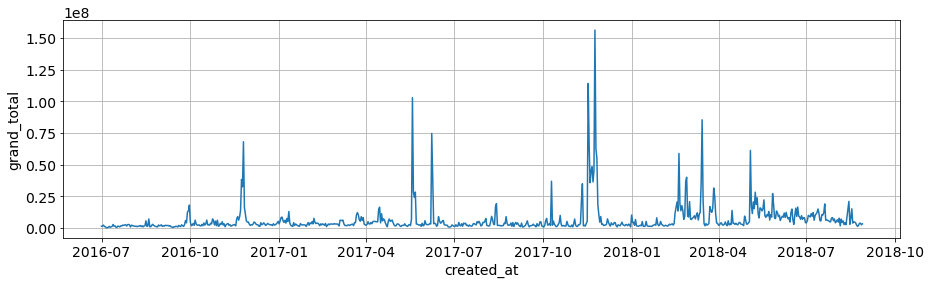

In [16]:
#Plotting graph between year and Total sales
sns.lineplot(x = "created_at" , y = "grand_total",data= p )
plt.show()

In [17]:
# p-value,Test statistics and Critical values as follows
results = adfuller(p['grand_total'])
print('Test Statistics: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values: ')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key,value))

Test Statistics: -6.759094
p-value: 0.000000
Critical Values: 
	1%: -3.439
	5%: -2.865
	10%: -2.569


## As dataset is Stationary but we can improve its stationarity by using following techniques
1. Difference with diff()
2. Log
3. Substracting previous value with Shift()
4. Differencing Simple Moving Average
5. Seasonal Decomposition

In [18]:
#1.Difference with diff()
df_stationary = p.diff().dropna()
result = adfuller(df_stationary)
print(result)

(-9.880550466636876, 3.7801923391704965e-17, 18, 769, {'1%': -3.438882201132452, '5%': -2.865305765357574, '10%': -2.568775270215655}, 26830.666943617696)


## 2.Log

In [19]:
indexeddataset_logscale = np.log(p['grand_total'])
result = adfuller(indexeddataset_logscale)
print(result)

(-5.880799078259279, 3.0817839899614744e-07, 7, 781, {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}, 1449.2854299497012)


## 3.Substracting previous value with Shift()

In [20]:
datasetLogDiffShifting = indexeddataset_logscale - indexeddataset_logscale.shift()
datasetLogDiffShifting.dropna(inplace=True)
result = adfuller(datasetLogDiffShifting)
print(result)

(-8.581567042024087, 7.70333630234363e-14, 20, 767, {'1%': -3.4389045244994096, '5%': -2.8653156040031176, '10%': -2.5687805115003}, 1462.400094333268)


## 4.Differencing Simple Moving Average

In [21]:
movingaverage = indexeddataset_logscale.rolling(window=12).mean()
movingstd = indexeddataset_logscale.rolling(window=12).std()
datasetlogscaleminusmovingaverage = indexeddataset_logscale - movingaverage
datasetlogscaleminusmovingaverage.dropna(inplace=True)
result = adfuller(datasetlogscaleminusmovingaverage)
print(result)

(-10.696900033271321, 3.6053483124295096e-19, 9, 768, {'1%': -3.4388933482333464, '5%': -2.8653106782623574, '10%': -2.5687778874376086}, 1314.665767332042)


## Differencing Simple Moving Average Provides us most suitable P-value and Test statistics

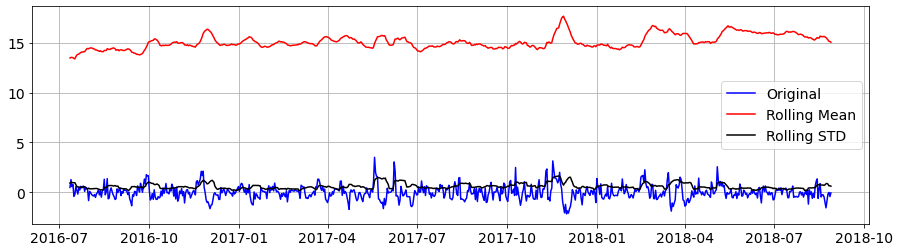

In [22]:
plot = plt.plot(datasetlogscaleminusmovingaverage,color='blue',label='Original')
mean = plt.plot(movingaverage, color='red',label='Rolling Mean')
std = plt.plot(movingstd, color='Black',label='Rolling STD')
plt.legend(loc='best')
#plt.title()
plt.show(block=True)

## 5.Seasonal Decomposition
##### By using this,we can find Seasonality,trends and residuals.

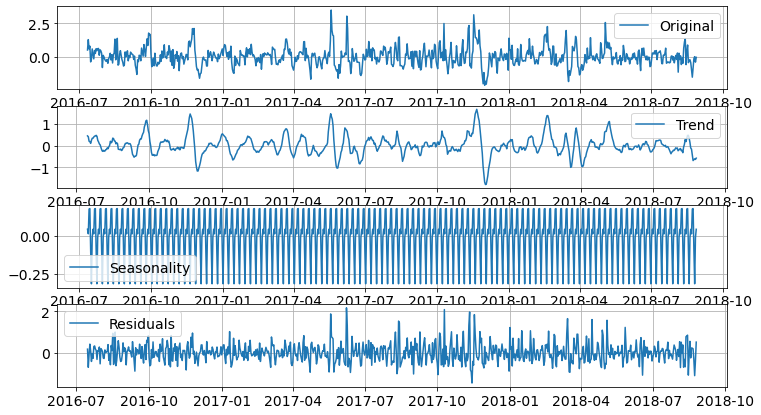

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(datasetlogscaleminusmovingaverage)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(12,7))
plt.subplot(411)
plt.plot(datasetlogscaleminusmovingaverage, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

In [24]:
datasetlogscaleminusmovingaverage.head()

created_at
2016-07-12    0.492259
2016-07-13    1.277309
2016-07-14    0.575696
2016-07-15    0.784320
2016-07-16   -0.402845
Name: grand_total, dtype: float64

In [25]:
type(datasetlogscaleminusmovingaverage)

pandas.core.series.Series

In [26]:
#Converting above from Series to dataframe
datasetlogscaleminusmovingaverage = pd.Series(datasetlogscaleminusmovingaverage)
new_dataset = datasetlogscaleminusmovingaverage.to_frame()
new_dataset.head()

,grand_total
created_at,
2016-07-12,0.492259
2016-07-13,1.277309
2016-07-14,0.575696
2016-07-15,0.784320
2016-07-16,-0.402845


In [27]:
type(new_dataset)

pandas.core.frame.DataFrame

# Applying ARIMA Model(Auto Regression)

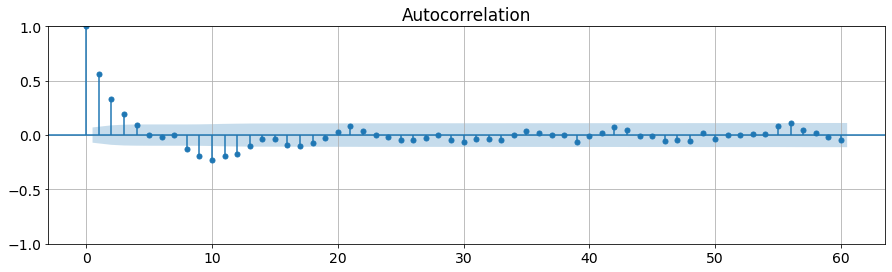

In [28]:
#Autocorrelation
ecom_df = new_dataset
acf(ecom_df, fft=False)
sm.graphics.tsa.plot_acf(ecom_df.values.squeeze(), lags=60);

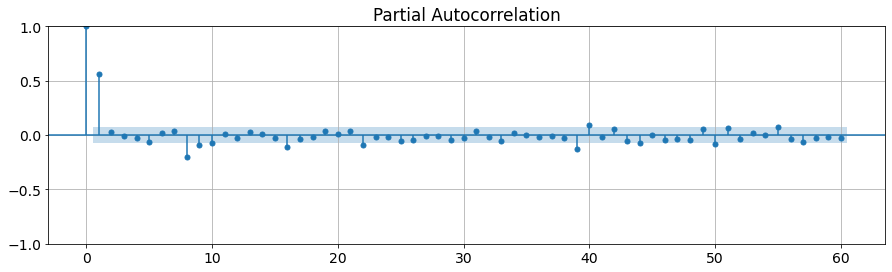

In [29]:
sm.graphics.tsa.plot_pacf(ecom_df.values.squeeze(), lags=60,
                         method='ols');

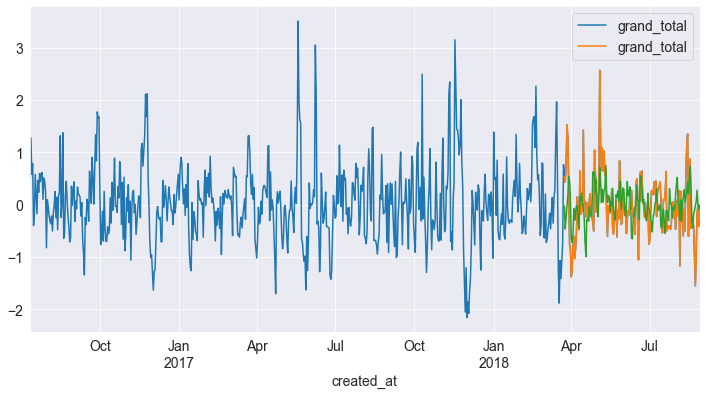

In [30]:
# Change frequency to day
ecom_df = new_dataset.asfreq('d')

# Set style for seaborn plot
sns.set_style('darkgrid')

# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
ax = ecom_df.plot(ax=ax)

# Creating model 
model = AutoReg(ecom_df['grand_total'],30)
model_fit = model.fit()

# Define training and testing area
len(ecom_df) # 778 observations
train_df = ecom_df.iloc[:620] 
test_df = ecom_df.iloc[620:] 

# Define training model for 159 days 
train_model = AutoReg(ecom_df['grand_total'], 159).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = train_model.predict(start=start, end=end, dynamic=True)
# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predicting Sales on Daily Time frame

<AxesSubplot:xlabel='created_at'>

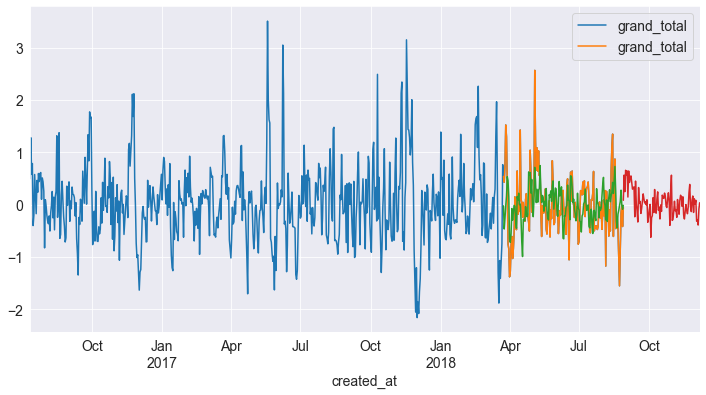

In [31]:
sns.mpl.rc('figure',figsize=(12, 6))
fig, ax = plt.subplots()
ax = ecom_df.plot(ax=ax)
model = AutoReg(ecom_df['grand_total'], 30)
model_fit = model.fit()
len(ecom_df) # 778 observations
train_df = ecom_df.iloc[:620] # 80%
test_df = ecom_df.iloc[620:] # Last 20%
# Define training model for 159 days 
train_model = AutoReg(ecom_df['grand_total'], 159).fit(cov_type="HC0")
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = train_model.predict(start=start, end=end, dynamic=True)
ax = test_df.plot(ax=ax) 
ax = prediction.plot(ax=ax) 

# Predict 100 days into the future
forecast = train_model.predict(start=end, end=end+100, dynamic=True)
forecast.plot(ax=ax) 

**In Above Graph, Different line Colours are used**
1. Red line shows predictions
2. Green Line shows training part of Dataset
3. Orange Line shows Test part of Dataset

In [32]:
mean_absolute_error(test_df, prediction)

0.4341050302371642

In [33]:
ecom_df = new_dataset.asfreq('m')
ecom_df.head()

,grand_total
created_at,
2016-07-31,-0.829195
2016-08-31,0.264442
2016-09-30,1.672717
2016-10-31,-0.607812
2016-11-30,-0.960756


# Predicting Sales on Monthly Time frame

<AxesSubplot:xlabel='created_at'>

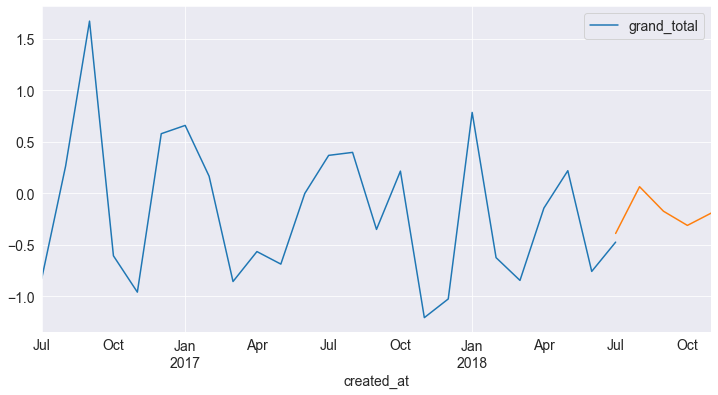

In [34]:
# Set style for seaborn plot
sns.set_style('darkgrid')

# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot monthly max temps
fig, ax = plt.subplots()
ax = ecom_df.plot(ax=ax)

# Creating model 
model = AutoReg(ecom_df['grand_total'],10)
model_fit = model.fit()

# Define training and testing area
len(ecom_df) # 25 observations
train_df = ecom_df.iloc[:16] 
test_df = ecom_df.iloc[16:] 

# Define training model for 5 days 
train_model = AutoReg(ecom_df['grand_total'], 5).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = train_model.predict(start=start, end=end, dynamic=True)

# Predict 4 months into the future
forecast = train_model.predict(start=end, end=end+4, dynamic=True)
forecast.plot(ax=ax)

In [35]:
mean_absolute_error(test_df, prediction)

0.571154791828094

# TRENDS

### Lets find out overall trend

In [36]:
dt = dt.sort_values('created_at')
#Adding New Features
dtg = dt.groupby('created_at')['grand_total'].sum().reset_index()
dtq = dt.groupby('created_at')['qty_ordered'].sum().reset_index()
dtd = dt.groupby('created_at')['discount_amount'].sum().reset_index()
#Comput count for non numeric values
dts = dt.groupby('created_at')['sku'].count().reset_index() 
dtst = dt.groupby('created_at')['status'].count().reset_index()
# new data set
p = pd.DataFrame(dtg) 
p['qty_ordered'] = dtq['qty_ordered']
p['discount_amount'] = dtd['discount_amount']
p['sku'] = dts['sku']
p['status'] = dtst['status']
#Cumulative Sum
p['cum_grand_total'] = p['grand_total'].cumsum()
p['cum_qty_ordered'] = p['qty_ordered'].cumsum()
p['cum_discount_amount'] = p['discount_amount'].cumsum()
p['cum_sku_cnt'] = p['sku'].cumsum()
p['cum_status_cnt'] = p['status'].cumsum()
# Date features
p['Dateofmonth'] = p['created_at'].dt.day
p['Month'] = p['created_at'].dt.month
p['Week'] = p['created_at'].dt.week
p['Dayofweek'] = p['created_at'].dt.dayofweek # 0 = monday.
p['Weekdayflg'] = (p['Dayofweek'] // 5 != 1).astype(float)
p['Month'] = p['created_at'].dt.month
p['Quarter'] = p['created_at'].dt.quarter
p['Dayofyear'] = p['created_at'].dt.dayofyear

p.head()

,created_at,grand_total,qty_ordered,discount_amount,sku,status,cum_grand_total,cum_qty_ordered,cum_discount_amount,cum_sku_cnt,cum_status_cnt,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2016-07-01,1301026.75,621,8100.0,547,547,1301026.75,621,8100.0,547,547,1,7,26,4,1.0,3,183
1,2016-07-02,1408450.48,301,2502.0,260,260,2709477.23,922,10602.0,807,807,2,7,26,5,0.0,3,184
2,2016-07-03,2215490.88,264,1501.0,210,210,4924968.11,1186,12103.0,1017,1017,3,7,26,6,0.0,3,185
3,2016-07-04,1094080.25,263,4406.0,229,229,6019048.36,1449,16509.0,1246,1246,4,7,27,0,1.0,3,186
4,2016-07-05,913053.50,194,5230.0,168,168,6932101.86,1643,21739.0,1414,1414,5,7,27,1,1.0,3,187


In [37]:
trend_df = p.iloc[:, 0:2]  
trend_df.head()

,created_at,grand_total
0,2016-07-01,1301026.75
1,2016-07-02,1408450.48
2,2016-07-03,2215490.88
3,2016-07-04,1094080.25
4,2016-07-05,913053.50


In [38]:
#Creating another column
trend_df['Year_month'] = trend_df['created_at'].apply(lambda x: x.strftime('%Y-%m'))
trend_df.head()

,created_at,grand_total,Year_month
0,2016-07-01,1301026.75,2016-07
1,2016-07-02,1408450.48,2016-07
2,2016-07-03,2215490.88,2016-07
3,2016-07-04,1094080.25,2016-07
4,2016-07-05,913053.50,2016-07


In [39]:
#Grouping Month Year
trend_df = trend_df.groupby('Year_month').sum()['grand_total'].reset_index()

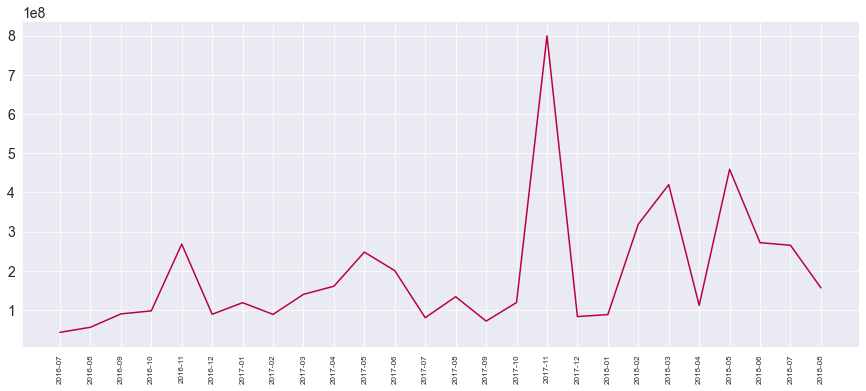

In [40]:
plt.figure(figsize=(15,6))
plt.plot(trend_df['Year_month'],trend_df['grand_total'],color='#b80045')
plt.xticks(rotation='vertical',size=8)
plt.show()

### We observe overall trend from july-2016 to aug-2018 and concluded following points
* #### Purchases increases in last Three months ( October,November and December ) of 2016 and 2017
* #### Most e-commerce buyers purchases products in November
* #### November is most suitable month for sellers to market their products
* #### Overall volume of ecommerce sales is increasing year by year 
* #### For example,you can compare first six months of 2017 with 2018